In [2]:
import os
from os import listdir
import glob

import multiprocessing as mp
import time

import numpy as np
import pandas as pd

from plyfile import PlyData, PlyElement
import open3d as o3d
from pyntcloud import PyntCloud

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# **READ IN MASTER PLY FILES**

In [4]:
ply0 = PlyData.read('../../data/paris_lille/paris_lille/Paris.ply')
ply1 = PlyData.read('../../data/paris_lille/paris_lille/Lille1.ply')
ply2 = PlyData.read('../../data/paris_lille/paris_lille/Lille1.ply')



def plyToData(ply_file):
    
    data = ply_file.elements[0].data

    data_pd = pd.DataFrame(data)
    data_np = np.zeros(data_pd.shape, dtype=np.float)
    property_names = data[0].dtype.names
    for i, name in enumerate(property_names):
        data_np[:,i] = data_pd[name]

    return data_pd


In [ ]:
data_pd0 = plyToData(ply0)
data_pd1 = plyToData(ply1)
data_pd2 = plyToData(ply2)

# **TURN EACH OBJECT INTO A PLY FILE**

In [12]:
def createPlyFile(df):
    
    for i in df.label.unique():
        df_ = df[df.label == i]
        
        if df_['class'].iloc[0] == 0 or df_['class'].iloc[0] == 100000000:
            continue
        else:
            file_name = "../../data/paris_lille/ply_objects/" + str(int(df_.iloc[0]['class'])) + "_" + str(int(df_.iloc[0].label)) + ".ply"
            data_np = df_[['x', 'y', 'z']].to_numpy()
            pcd = o3d.geometry.PointCloud()
            pcd.points = o3d.utility.Vector3dVector(data_np)
            o3d.io.write_point_cloud(file_name, pcd)

In [13]:
num_cores = mp.cpu_count()
pool = mp.Pool(num_cores)

start = time.time()
ply_files = pool.map(createPlyFile, [data_pd0, data_pd1, data_pd2])
end = time.time()
print(end - start)

pool.close()

168.01552319526672


# **VOXELIZE EACH PLY FILE**

In [14]:
path = os.path.join('../../data/paris_lille/ply_objects', '*.ply')

for ply_file in glob.iglob(path):
    
    ply = PyntCloud.from_file(ply_file)
    voxelgrid_id = ply.add_structure('voxelgrid', n_x=32, n_y=32, n_z=32)
    voxelgrid = ply.structures[voxelgrid_id]
    binary_feature_vector = voxelgrid.get_feature_vector(mode='binary')
    
    file_name = '../../data/paris_lille/npy_objects_method2/' + ply_file.split('/')[-1].split('.')[0] + '.npy'
    np.save(file_name, binary_feature_vector)

# **INSPECT FILES**

In [15]:
def plot3DVoxel(voxels):
    fig = plt.figure('Point Cloud 3D Voxelization')
    plt3d = fig.gca(projection='3d')

    occupied = (voxels == 1)
    free = (voxels == 0)

    # # set the colors of each object
    colors = np.zeros(voxels.shape + (4,))
    colors[free] = [0.1, 0.1, 0.1, 0.1]
    colors[occupied] = [0.8, 0.8, 0.8, 1.0]

    # setting camera angle
    plt3d.set_xlabel('X', fontsize=9)
    plt3d.set_ylabel('Y', fontsize=9)
    plt3d.set_zlabel('Z', fontsize=9)
    plt3d.set_xlim3d(0, voxels.shape[0])
    plt3d.set_ylim3d(0, voxels.shape[1])
    plt3d.set_zlim3d(0, voxels.shape[2])

    # and plot everything
    # plt3d.voxels(occupied | free, facecolors=colors, edgecolor='k', linewidth=0.8)
    plt3d.voxels(occupied, facecolors=colors, edgecolor='k', linewidth=0.8)

    dx, dy, dz = voxels.shape
    x = y= z = 0
    xx = [x, x, x+dx, x+dx, x]
    yy = [y, y+dy, y+dy, y, y]
    kwargs = {'alpha': 1, 'color': 'red'}
    plt3d.plot3D(xx, yy, [z]*5, **kwargs)
    plt3d.plot3D(xx, yy, [z+dz]*5, **kwargs)
    plt3d.plot3D([x, x], [y, y], [z, z+dz], **kwargs)
    plt3d.plot3D([x, x], [y+dy, y+dy], [z, z+dz], **kwargs)
    plt3d.plot3D([x+dx, x+dx], [y+dy, y+dy], [z, z+dz], **kwargs)
    plt3d.plot3D([x+dx, x+dx], [y, y], [z, z+dz], **kwargs)

    plt.show()

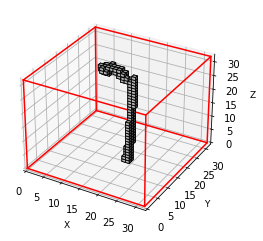

In [16]:
voxels = np.load('../../data/paris_lille/npy_objects_method2/302020400_159.npy')
plot3DVoxel(voxels)